In [1]:
!pip install --user -r requirements.txt

     |████████████████████████████████| 881.9 MB 2.0 kB/s s eta 0:00:01     |███████████▎                    | 312.1 MB 130.4 MB/s eta 0:00:05�█████████████████▏    | 747.3 MB 123.1 MB/s eta 0:00:02
     |████████████████████████████████| 15.7 MB 37.8 MB/s eta 0:00:01
  Using cached wilds-1.2.2-py3-none-any.whl (92 kB)
     |████████████████████████████████| 23.3 MB 42.6 MB/s eta 0:00:01
  Using cached wandb-0.12.6-py2.py3-none-any.whl (1.7 MB)
  Using cached promise-2.3.tar.gz (19 kB)
  Using cached GitPython-3.1.24-py3-none-any.whl (180 kB)
     |████████████████████████████████| 140 kB 69.0 MB/s eta 0:00:01
  Using cached pathtools-0.1.2.tar.gz (11 kB)
  Using cached shortuuid-1.0.8-py3-none-any.whl (9.5 kB)
     |████████████████████████████████| 1.1 MB 49.3 MB/s eta 0:00:01
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached subprocess32-3.5.4.tar.gz (97 kB)
  Using cached yaspin-2.1.0-py3-none-any.whl (18 kB)
  Using cached outdated-0.2.1-py3-none-any

In [31]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as T
from tqdm.auto import tqdm

from training_pipeline import calculate_epoch_metrics, do_phase, get_dataloaders, initialize_model
from models import *

In [45]:
MODEL_NAME = 'resnet' # or 'densenet' or whatever
DATASET = 'iwildcam' # or 'camelyon17' or 'iwildcam'
CORRELATION_SOURCE = 0.5

In [46]:
def get_model(model_file):
    model = initialize_model(
         MODEL_NAME,
         2, # num classes is always 2
         True, # set this feature extraction flag to true to freeze stuff
         use_pretrained=False
    )
    try:
        weights = torch.load(model_file).state_dict() 
    except Exception: # need to extract the state dict from the model file
        weights = torch.load(model_file, map_location='cpu')
    model.load_state_dict(weights)
    model.to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    return model

def get_dataloader(correlation):
    _, test_dl = get_dataloaders(
        DATASET,
        "/scratch/eecs542f21_class_root/eecs542f21_class/shared_data/dssr_datasets/WildsData/",
        CORRELATION_SOURCE,
        42, # seed
        32, # batch_size
        os.cpu_count() // 2,
        test_only=True,
        augment=False,
        rand_args=[0,0],
    )
    return test_dl

def run_inference(model, dataloader):
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    _, _, all_y, all_preds, all_scores, _, all_domains, all_domain_preds, all_domain_scores = do_phase('val', model, pbar)
    return all_y, all_preds, all_scores, all_domains, all_domain_preds, all_domain_scores

def compare_predictions(baseline_model, skewed_model, correlation):
    print("Loading datasets...")
    dl = get_dataloader(correlation)
    
    print("Running inference...")
    results_base = run_inference(baseline, dl)
    results_skewed = run_inference(skewed, dl)
    _, preds_base, all_domains, *_ = results_base
    _, preds_skewed, *_ = results_skewed
    # TODO: maybe store the rest of the results and compute metrics, idk
    return preds_base, preds_skewed, dl.dataset # this only works because shuffle = False

In [47]:
BASELINE_PATH = "/scratch/eecs542f21_class_root/eecs542f21_class/shared_data/dssr_datasets/saved_models/iwildcam/iwildcam_baseline_corr0.5/best_val_acc.pth"
SKEWED_PATH = "/scratch/eecs542f21_class_root/eecs542f21_class/shared_data/dssr_datasets/saved_models/iwildcam/iwildcam_baseline_corr0.9/best_val_acc.pth"

print("Loading model...")
baseline = get_model(BASELINE_PATH)
skewed = get_model(SKEWED_PATH)
preds_base, preds_skewed, dataset = compare_predictions(baseline, skewed, CORRELATION_SOURCE)


Loading model...
Loading datasets...
Running inference...


/home/ctrenton/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/60 [00:00<?, ?it/s]

/home/ctrenton/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/60 [00:00<?, ?it/s]

In [56]:
preds_base[indices]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

# of examples in group: 417
# of examples total: 1893


<ipython-input-53-1f6573f261f0>:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4, 4))


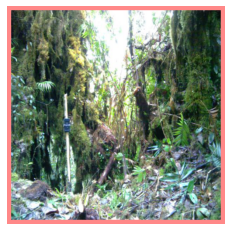

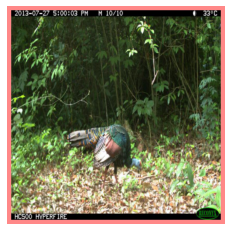

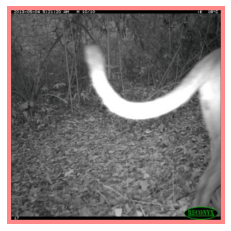

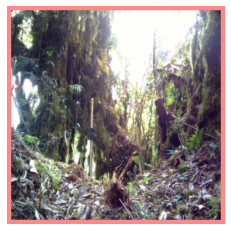

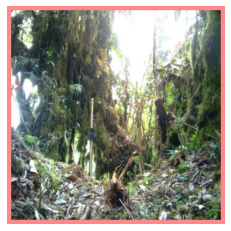

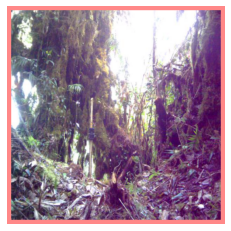

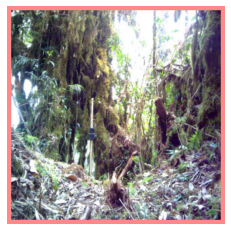

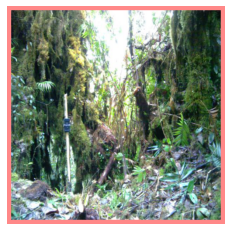

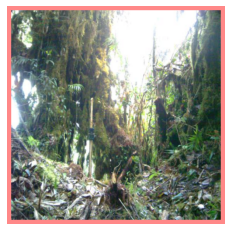

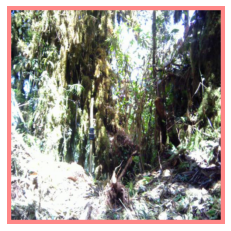

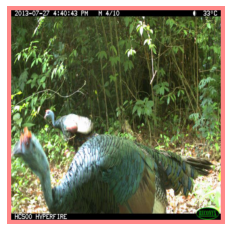

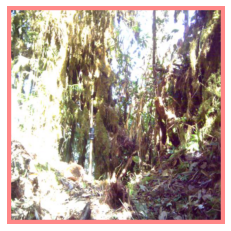

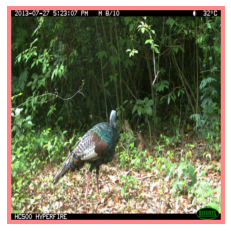

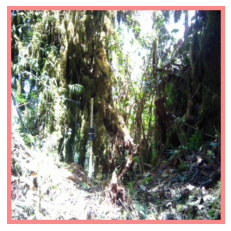

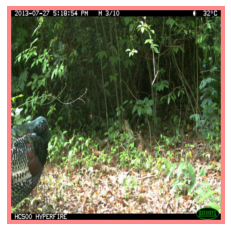

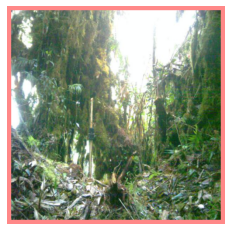

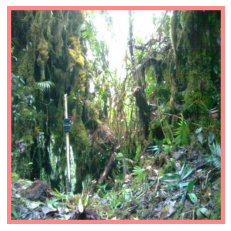

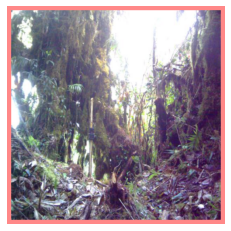

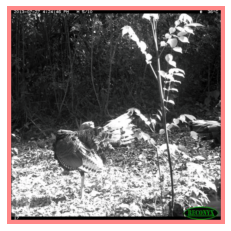

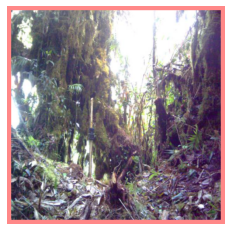

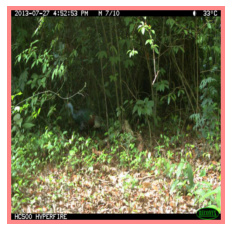

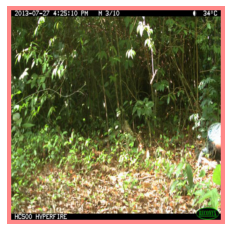

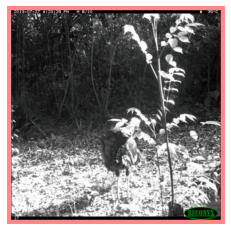

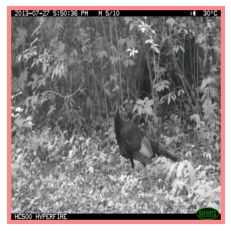

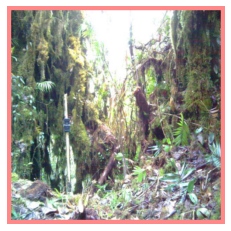

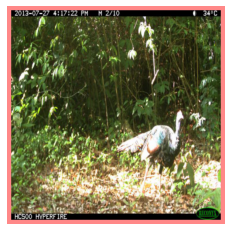

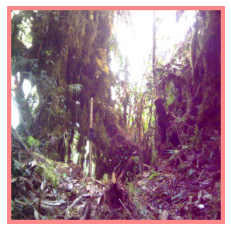

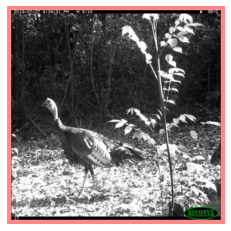

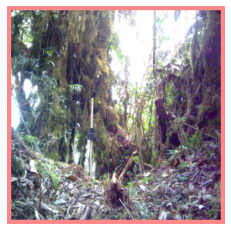

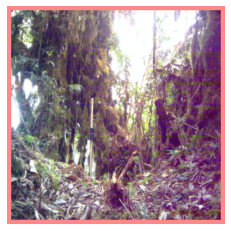

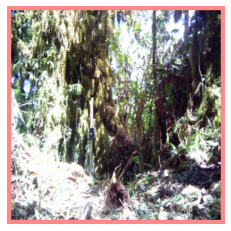

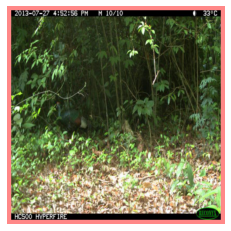

In [53]:
N_EXAMPLES_TO_VISUALIZE = 32
EXAMPLE_TYPE = 'flipped' # or 'robust' or 'hard'

np.random.seed(42) # change this to see diff examples -- for reproducibility. Original is 42.

if EXAMPLE_TYPE == 'flipped':
    preds = (preds_base == 1) & (preds_skewed == 0) 
elif EXAMPLE_TYPE == 'robust':
    preds = (preds_base == 1) & (preds_skewed == 1)
elif EXAMPLE_TYPE == 'hard':
    preds = (preds_base == 0) & (preds_skewed == 0) 
    
STDS = torch.tensor([0.229, 0.224, 0.225])[(..., ) + (None, ) * 2]
MEANS = torch.tensor([0.485, 0.456, 0.406])[(..., ) + (None, ) * 2]

    
print("# of examples in group:", preds.sum().item())
print("# of examples total:", len(preds))

indices = np.random.choice(np.where(preds.detach().cpu().squeeze() == 1)[0], N_EXAMPLES_TO_VISUALIZE)

def frame_image(img, frame_width, color="#ff8888"):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    framed_img = np.zeros((nx+2*b, ny+2*b, 3), dtype=int)
    framed_img[..., 0] = int(f"0x{color[1:3]}", 16)
    framed_img[..., 1] = int(f"0x{color[3:5]}", 16)
    framed_img[..., 2] = int(f"0x{color[5:]}", 16)
    framed_img[b:-b, b:-b] = img
    return framed_img

def show_spurious_correlations(indices, frame=True, normalized=True, spurious_class1_color="#ff8888", spurious_class0_color="#ff8888", border_width=9):
    for i in indices:
        X, y, z = dataset[i]
        if normalized:
            X.mul_(STDS).add_(MEANS)
        img = np.array(T.to_pil_image(X)).astype(int)
        fig = plt.figure(figsize=(4, 4))
        ax = fig.subplots(1, 1)
        axis = ax.axis()
        if frame:
            if y == 1 and z == 1: # fooled by spurious correlation, class 1
                img = frame_image(img, border_width, color=spurious_class1_color)
            if y == 0 and z == 0: # fooled by spurious correlation, class 0
                img = frame_image(img, border_width, color=spurious_class0_color)
        ax.set_axis_off()
        ax.imshow(img)

show_spurious_correlations(indices)


In [49]:
# right-click to save images for figures

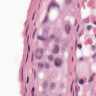

In [18]:
from PIL import Image
img = Image.open(os.path.join(dataset.data_dir, dataset.paths[0])).convert('RGB')
img

In [25]:
from torchvision import transforms as T

preprocess = T.Compose(
            [
                T.Resize((96, 96)),
                T.ToTensor(),
            ]
        )

preprocess(img)

tensor([[[0.9804, 0.9765, 0.9765,  ..., 0.7843, 0.9098, 0.8706],
         [0.9765, 0.9765, 0.9765,  ..., 0.7725, 0.8941, 0.8588],
         [0.9765, 0.9765, 0.9765,  ..., 0.7725, 0.8706, 0.8588],
         ...,
         [0.9765, 0.9765, 0.9765,  ..., 0.8078, 0.8235, 0.7961],
         [0.9765, 0.9765, 0.9765,  ..., 0.8157, 0.8078, 0.7922],
         [0.9725, 0.9725, 0.9725,  ..., 0.8275, 0.8078, 0.8078]],

        [[0.9765, 0.9765, 0.9765,  ..., 0.5490, 0.6392, 0.6275],
         [0.9765, 0.9765, 0.9765,  ..., 0.5137, 0.6196, 0.6627],
         [0.9765, 0.9765, 0.9765,  ..., 0.5020, 0.6000, 0.6471],
         ...,
         [0.9725, 0.9686, 0.9725,  ..., 0.6078, 0.5882, 0.5529],
         [0.9725, 0.9686, 0.9725,  ..., 0.6314, 0.5686, 0.5373],
         [0.9725, 0.9686, 0.9725,  ..., 0.6824, 0.5922, 0.5529]],

        [[0.9725, 0.9765, 0.9765,  ..., 0.6353, 0.7333, 0.7608],
         [0.9765, 0.9765, 0.9804,  ..., 0.6235, 0.7216, 0.7451],
         [0.9765, 0.9765, 0.9804,  ..., 0.6275, 0.7255, 0.